In [ ]:
!pip install gdown transformers torch sentence_transformers pyvi

In [ ]:
import pandas as pd
import torch
from torch import nn
import transformers
from transformers import AutoModel, AutoTokenizer

In [ ]:
import torch
import numpy as np
from transformers import AutoModel, AutoTokenizer
from pyvi.ViTokenizer import tokenize

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

PhobertTokenizer = AutoTokenizer.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base")
model = AutoModel.from_pretrained("VoVanPhuc/sup-SimCSE-VietNamese-phobert-base").to(device)

In [ ]:
def simi(str1: str, str2: str):
  sentences = []
  sentences.append(str1)
  sentences.append(str2)

  sentences = [tokenize(sentence) for sentence in sentences]

  inputs = PhobertTokenizer(sentences, padding=True, truncation=True, return_tensors="pt").to(device)

  with torch.no_grad():
      embeddings = model(**inputs, output_hidden_states=True, return_dict=True).pooler_output.to(device)

  # Assuming embeddings is a list of PyTorch tensors
  embedding1 = embeddings[0].cpu().numpy()
  embedding2 = embeddings[1].cpu().numpy()

  dot_product = np.dot(embedding1, embedding2)
  norm_product = np.linalg.norm(embedding1) * np.linalg.norm(embedding2)
  cosine_similarity = dot_product / norm_product

  return cosine_similarity

In [ ]:
Claim = "Tình trạng u tủy sống thường gặp ở trẻ em, rất ít xảy ra với người lớn."
evidence = "Tình trạng u tủy sống thường gặp ở người lớn, rất ít xảy ra với trẻ em."
simi(Claim, evidence)

0.6721538

In [ ]:
def calculate_new_word_ratio(sentence, context):
    sentence_words = sentence.lower().split()
    context_words = context.lower().split()

    num_new_token = 0
    for i in range(len(sentence_words)):
      if(sentence_words[i] not in context_words):
        num_new_token +=1
    return num_new_token

In [ ]:
!gdown '1dGeenoB_kfwGs4kY5mpiTM581cfEsJ_u'
!gdown '1W8tF13hEASyUQJFWhuc8wKn2OoW9H0_O'

Downloading...
From: https://drive.google.com/uc?id=1dGeenoB_kfwGs4kY5mpiTM581cfEsJ_u
To: /content/data.csv
100% 260M/260M [00:05<00:00, 50.3MB/s]
Downloading...
From: https://drive.google.com/uc?id=1W8tF13hEASyUQJFWhuc8wKn2OoW9H0_O
To: /content/data_private_test.csv
100% 35.9M/35.9M [00:00<00:00, 44.8MB/s]


In [ ]:
data = pd.read_csv("data.csv")
data_test = pd.read_csv("data_private_test.csv")

In [ ]:
import json
with open("/content/private_result.json") as f:
    json_data = json.load(f)
x = pd.DataFrame.from_dict(json_data, orient="index")
a = x.verdict.tolist()
data_test['verdict'] = a

In [ ]:
import string

def longest_common_subsequence(str1, str2):
    tokens1 = str1.split()
    tokens2 = str2.split()

    m, n = len(tokens1), len(tokens2)

    # Create a 2D table to store the LCS lengths
    lcs_lengths = [[0] * (n + 1) for _ in range(m + 1)]

    # Fill the table using dynamic programming
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            if tokens1[i - 1] == tokens2[j - 1]:
                lcs_lengths[i][j] = lcs_lengths[i - 1][j - 1] + 1
            else:
                lcs_lengths[i][j] = max(lcs_lengths[i - 1][j], lcs_lengths[i][j - 1])

    # Reconstruct the LCS from the table
    lcs = []
    i, j = m, n
    while i > 0 and j > 0:
        if tokens1[i - 1] == tokens2[j - 1]:
            lcs.insert(0, tokens1[i - 1])
            i -= 1
            j -= 1
        elif lcs_lengths[i - 1][j] > lcs_lengths[i][j - 1]:
            i -= 1
        else:
            j -= 1

    lcs = [token for token in lcs if token not in string.punctuation]
    lcs_join = ' '.join(lcs)
    return len(lcs)/n

In [ ]:
import re
def preprocess_text(text: str) -> str:
    text = re.sub(r"['\",\.\?:\-!]", "", text)
    text = text.strip()
    text = " ".join(text.split())
    text = text.lower()
    return text

In [ ]:
count = 0
for i in range(len(data_test)):
  # LCS = longest_common_subsequence(preprocess_text(data_test.claim[i]), preprocess_text(data_test.evidence[i]))
  LCS = longest_common_subsequence(preprocess_text(data_test.evidence[i]), preprocess_text(data_test.claim[i]))
  if(LCS >= 0.95):
    count = count + 1
    print("ID: ", i)
    print("Claim: ", data_test.claim[i])
    print("evidence: ", data_test.evidence[i])
print(count)

In [ ]:
count = 0
for i in range(len(data_test)):
  # LCS = longest_common_subsequence(preprocess_text(data_test.claim[i]), preprocess_text(data_test.evidence[i]))
  if(preprocess_text(data_test.evidence[i]) == preprocess_text(data_test.claim[i])):
    count = count + 1
    print("ID: ", i)
    print("Claim: ", data_test.claim[i])
    print("evidence: ", data_test.evidence[i])
print(count)

In [ ]:
import matplotlib.pyplot as plt

lengths_support = []
len_sup = []
lengths_refuted = []
len_ref = []
lengths_NEI = []
len_nei = []

for i in range(len(data)):
    LCS = longest_common_subsequence(data.claim[i], data.evidence_top1[i])
    if data.verdict[i] == "SUPPORTED":
        lengths_support.append((LCS))
    elif data.verdict[i] == "REFUTED":
        lengths_refuted.append((LCS))
    else:
        lengths_NEI.append((LCS))

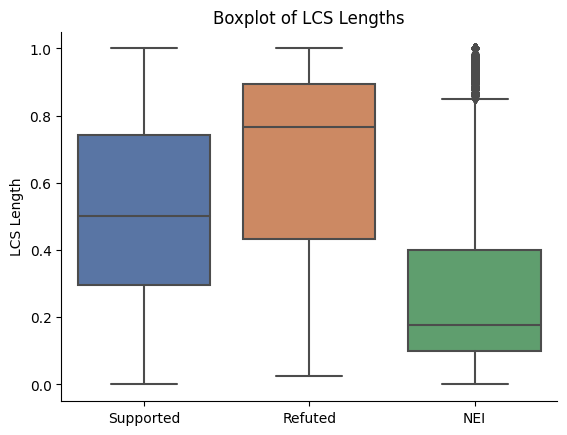

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
hi = [lengths_support, lengths_refuted, lengths_NEI]

# Create a figure and axis
fig, ax = plt.subplots()
# Set the style using Seaborn
sns.set(style="ticks")

# Create the boxplot using Seaborn
bp = sns.boxplot(data=hi, ax=ax)

# Set the x-axis labels
ax.set_xticklabels(['Supported', 'Refuted', 'NEI'])

# Set the title
ax.set_title('Boxplot of LCS Lengths')

# Set the y-axis label
ax.set_ylabel('LCS Length')

# Remove the top and right spines
sns.despine()

# Show the plot
plt.show()

In [ ]:
count = 0
for i in range(len(data)):
  # LCS = longest_common_subsequence(preprocess_text(data_test.claim[i]), preprocess_text(data_test.evidence[i]))
  if(preprocess_text(data.evidence_top1[i]) == preprocess_text(data.claim[i])):
    if(data.verdict[i] == "NEI"):
      count = count + 1
      print("ID: ", i)
      print("Claim: ", data.claim[i])
      print("evidence: ", data.evidence[i])
print(count)

In [ ]:
count = 0
count_refuted = 0
for i in range(len(data)):
  LCS = longest_common_subsequence(preprocess_text(data.evidence_top1[i]), preprocess_text(data.claim[i]))
  if(LCS >= 0.95):
  # if(preprocess_text(data.evidence_top1[i]) == preprocess_text(data.claim[i])):
      count = count + 1
      if(data.verdict[i] == "REFUTED"):
        count_refuted = count_refuted + 1
print(count_refuted/count)

0.21810971579643093


In [ ]:
count = 0
for i in range(len(data_test)):
  LCS = longest_common_subsequence(preprocess_text(data_test.claim[i]), preprocess_text(data_test.evidence[i]))
  word = calculate_new_word_ratio(preprocess_text(data_test.claim[i]), preprocess_text(data_test.evidence[i]))
  # if(LCS >= 0.90 and word >= 1 and word <= 2):
  if(LCS >= 0.90 and word == 1):
    count = count + 1
    print("ID: ", i)
    print("Claim: ", data_test.claim[i])
    print("evidence: ", data_test.evidence[i])
print(count)

In [ ]:
count = 0
similar = []
labels = []
for i in range(len(data)):
  x = preprocess_text(data.claim[i])
  y = preprocess_text(data.evidence_top1[i])
  LCS = longest_common_subsequence(x,y)
  word = calculate_new_word_ratio(x,y)
  # if(LCS >= 0.90 and word >= 1 and word <= 2):
  # if(data.verdict[i] == "NEI"):
  if(LCS >= 0.90 and word == 1):
    similar.append(z)
    count = count + 1
    print("ID: ", i)
    print("Claim: ", data.claim[i])
    print("evidence: ", data.evidence_top1[i])
    print(data.verdict[i])
print(count)

In [ ]:
count = 0
similar = []
labels = []
for i in range(len(data)):
  x = preprocess_text(data.claim[i])
  y = preprocess_text(data.evidence_top1[i])
  LCS = longest_common_subsequence(x,y)
  word = calculate_new_word_ratio(x,y)
  if(LCS >= 0.90 and word == 1):
    z = simi(x, y)
    similar.append(z)
    count += 1
    labels.append(data.verdict[i])
    if(z < 0.83 ):
      print("ID: ", i)
      print("Claim: ", data.claim[i])
      print("evidence: ", data.evidence_top1[i])
      print("simi:" z)
      print(data.verdict[i])
print(count)

<Figure size 1000x600 with 0 Axes>

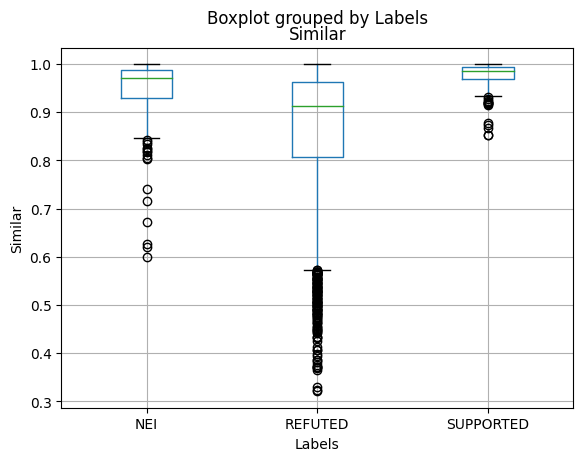

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Tạo DataFrame từ similar và labels
df = pd.DataFrame({'Similar': similar, 'Labels': labels})

# Tạo boxplot
plt.figure(figsize=(10, 6))
df.boxplot(column='Similar', by='Labels')
plt.xlabel('Labels')
plt.ylabel('Similar')
plt.show()

* SUP: 186
* REF: 2838
* NEI: 273

# SET UP 1

In [ ]:
data_test.head(5)

,context,claim,id,evidence_top5,evidence,top5,top3,top2,verdict
0,"Sáng 7/6, bà Nguyễn Thị Lệ Thanh, Giám đốc Sở ...",Xuyên suốt thời gian diễn ra Festival biển Nha...,39773,"['Người đứng đầu Sở Du lịch Khánh Hòa cho hay,...","Người đứng đầu Sở Du lịch Khánh Hòa cho hay, x...",[CLS] người đứng đầu sở du lịch khánh hòa cho ...,[CLS] người đứng đầu sở du lịch khánh hòa cho ...,[CLS] người đứng đầu sở du lịch khánh hòa cho ...,NEI
1,"Còn với Công nghệ dệt may, em không biết may h...",Một số người khuyên Nhi Pham theo Công nghệ th...,37657,['Một số người khuyên em theo Công nghệ thực p...,Một số người khuyên em theo Công nghệ thực phẩ...,[CLS] một số người khuyên em theo công nghệ th...,[CLS] một số người khuyên em theo công nghệ th...,[CLS] một số người khuyên em theo công nghệ th...,REFUTED
2,Nhà nghiên cứu Guangming Tao ở Đại học Khoa họ...,Nhiệt độ da bên dưới lớp cotton cao làm người ...,40265,['Nhiệt độ da bên dưới vải siêu mát tăng từ kh...,Nhiệt độ da bên dưới vải siêu mát tăng từ khoả...,[CLS] nhiệt độ da bên dưới vải siêu mát tăng t...,[CLS] nhiệt độ da bên dưới vải siêu mát tăng t...,[CLS] nhiệt độ da bên dưới vải siêu mát tăng t...,NEI
3,"Trong không gian của du thuyền 5 sao, Shynh Ho...",Nhãn hàng sẽ cùng 6 đối tác đề ra những chiến ...,47711,['Nhãn hàng sẽ cùng đối tác đề ra những chiến ...,Nhãn hàng sẽ cùng đối tác đề ra những chiến lư...,[CLS] nhãn hàng sẽ cùng đối tác đề ra những ch...,[CLS] nhãn hàng sẽ cùng đối tác đề ra những ch...,[CLS] nhãn hàng sẽ cùng đối tác đề ra những ch...,REFUTED
4,Pin sinh học là giải pháp mới để cung cấp năng...,Bụi thông minh chỉ cần 5 tế bào vi khuẩn cũng ...,39930,"['""Chúng tôi gọi đó là \\'bụi thông minh\\' và...","""Chúng tôi gọi đó là 'bụi thông minh' và chỉ v...",[CLS] chúng tôi gọi đó là bụi thông minh và ch...,[CLS] chúng tôi gọi đó là bụi thông minh và ch...,[CLS] chúng tôi gọi đó là bụi thông minh và ch...,NEI


## LCS >= 0.9 word == 1 simi < 0.8 => mo hinh du doan 26

In [ ]:
count = 0
label = 0
for i in range(len(data_test)):
  x = preprocess_text(data_test.claim[i])
  y = preprocess_text(data_test.evidence[i])
  LCS = longest_common_subsequence(x,y)
  word = calculate_new_word_ratio(x,y)
  if(LCS >= 0.90 and word == 1):
    z = simi(data_test.claim[i] , data_test.evidence[i])
    if(z < 0.75):
      if(data_test.verdict[i] != "REFUTED"):
        count = count + 1
        print("ID: ", i, z)
        print("Claim: ", data_test.claim[i])
        print("evidence: ", data_test.evidence[i])
        print(data_test.verdict[i])
        # data_test.verdict[i] = "REFUTED"
print(count, label)

ID:  907 0.73276645
Claim:  Các kỹ sư muốn tham gia vào lĩnh vực lập trình hệ thống có thể sử dụng ngôn ngữ Go.
evidence:  Các kỹ sư muốn tham gia vào lĩnh vực lập trình hệ thống có thể sử dụng ngôn ngữ này .
SUPPORTED
ID:  2344 0.74826866
Claim:  Mirabile cũng thỉnh thoảng uống đồ có cồn vào những buổi tụ tập bạn bè.
evidence:  Anh cũng thỉnh thoảng uống đồ có cồn vào những buổi tụ tập bạn bè.
SUPPORTED
2 0


## word_c_e = word_e_c = 0 249

In [ ]:
data_test.head(1)

,context,claim,id,evidence_top5,evidence,top5,top3,top2,verdict
0,"Sáng 7/6, bà Nguyễn Thị Lệ Thanh, Giám đốc Sở ...",Xuyên suốt thời gian diễn ra Festival biển Nha...,39773,"['Người đứng đầu Sở Du lịch Khánh Hòa cho hay,...","Người đứng đầu Sở Du lịch Khánh Hòa cho hay, x...",[CLS] người đứng đầu sở du lịch khánh hòa cho ...,[CLS] người đứng đầu sở du lịch khánh hòa cho ...,[CLS] người đứng đầu sở du lịch khánh hòa cho ...,SUPPORTED


In [ ]:
count = 0
label = 0
for i in range(len(data_test)):
  x = preprocess_text(data_test.claim[i])
  y = preprocess_text(data_test.evidence[i])
  # LCS = longest_common_subsequence(x,y)
  word_c_e = calculate_new_word_ratio(x,y)
  word_e_c = calculate_new_word_ratio(y,x)
  if( word_c_e == 0 and word_e_c == 0):
      z = simi( data_test.claim[i] , data_test.evidence[i])
      if(z > 0.97):
        if(data_test.verdict[i] != "SUPPORTED"):
          count = count + 1
          print(z)
          print("ID: ", data_test.id[i])
          print("Claim: ", data_test.claim[i])
          print("evidence: ", data_test.evidence[i])
          print(data_test.verdict[i])
          # data_test.verdict[i] = "SUPPORTED"
print(count, label)

0.98781073
ID:  42784
Claim:  Anh Vũ Duy (Beauty Blogger Call Me Duy) - quán quân chương trình KOC Việt Nam 2022, cho biết Esunvy là dòng sản phẩm được anh thường xuyên sử dụng trong thời gian gần đây vì giá thành ổn và có hiệu quả tốt.
evidence:  Anh Vũ Duy (Beauty Blogger Call Me Duy) - quán quân chương trình KOC Việt Nam 2022 cho biết: "Esunvy là dòng sản phẩm được Duy thường xuyên sử dụng trong thời gian gần đây vì giá thành ổn và có hiệu quả tốt .
REFUTED
0.9961044
ID:  44179
Claim:  Ông Hùng không tìm được chỗ gửi xe đành "đậu liều" ở ngoài đường, cách nhà hơn 300 m
evidence:  Ông Hùng không tìm được chỗ gửi xe đành "đậu liều" ở ngoài đường, cách nhà hơn 300 m.
NEI
0.9893047
ID:  42915
Claim:  Sở Giáo dục và Đào tạo Nghệ An nhận định sau nhiều năm, "phụ huynh, học sinh đã thay đổi nhận thức trong định hướng nghề nghiệp, không còn nghĩ vào đại học là con đường duy nhất để lập nghiệp".
evidence:  Sau nhiều năm, Sở Giáo dục và Đào tạo Nghệ An nhận định "phụ huynh học sinh đã thay đổ

## claim = claim

In [ ]:
count = 0

for i in range(len(data_test)):
  x = preprocess_text(data_test.claim[i])
  y = preprocess_text(data_test.evidence[i])
  if(x == y):
    if(data_test.verdict[i] != "SUPPORTED"):
      count = count + 1
      print("ID: ", i)
      print("Claim: ", data_test.claim[i])
      print("evidence: ", data_test.evidence[i])
      print(data_test.verdict[i])
      data_test.verdict[i] = "SUPPORTED"
print(count)

0


In [ ]:
data_submit = data_test.copy()
data_submit = data_submit.drop(['context', 'claim', 'evidence_top5', 'top3', 'top5', 'top2'], axis=1)
data_submit.head(3)

,id,evidence,verdict
0,39773,"Người đứng đầu Sở Du lịch Khánh Hòa cho hay, x...",SUPPORTED
1,37657,Một số người khuyên em theo Công nghệ thực phẩ...,REFUTED
2,40265,Nhiệt độ da bên dưới vải siêu mát tăng từ khoả...,NEI


In [ ]:
# for i in range(len(data_submit)):
#     if(data_submit['verdict'][i] == 2):
#         data_submit['evidence'][i] =""

for i in range(len(data_submit)):
    if(data_submit['verdict'][i] == "NEI"):
        data_submit['evidence'][i] =""

<ipython-input-57-5356eb1f0ce1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_submit['evidence'][i] =""


In [ ]:
data_submit

,id,evidence,verdict
0,39773,"Người đứng đầu Sở Du lịch Khánh Hòa cho hay, x...",SUPPORTED
1,37657,Một số người khuyên em theo Công nghệ thực phẩ...,REFUTED
2,40265,,NEI
3,47711,Nhãn hàng sẽ cùng đối tác đề ra những chiến lư...,REFUTED
4,39930,,NEI
...,...,...,...
5391,37369,,NEI
5392,37108,Ứng viên có thể thông qua mạng lưới bạn bè hoặ...,REFUTED
5393,37834,"Tuy nhiên, chỉ số đường huyết của bệnh nhân lú...",REFUTED
5394,43741,Cơ quan Giáo dục New Zealand (ENZ) hôm 5/1 cho...,SUPPORTED


In [ ]:
data_submit['verdict'] = data_submit['verdict'].replace(0,"SUPPORTED")
data_submit['verdict'] = data_submit['verdict'].replace(1,"REFUTED")
data_submit['verdict'] = data_submit['verdict'].replace(2,"NEI")

In [ ]:
import zipfile
import json

output = {}
for _, row in data_submit.iterrows():
    output[str(row['id'])] = {
       'verdict': row['verdict'],
        'evidence': row['evidence']
    }

# Chuyển output thành chuỗi JSON
json_str = json.dumps(output, indent=4, ensure_ascii=False)

with open('private_result.json', 'w', encoding='utf-8') as f:
    json.dump(output, f, ensure_ascii=False, indent=4)

# Tạo đối tượng ZipFile
with zipfile.ZipFile('results.zip', 'w') as zipf:
    zipf.writestr('private_result.json', json_str)

print("Done.")

Done.


In [ ]:
distribution = data_submit['verdict'].value_counts()
print(distribution)

REFUTED      2299
SUPPORTED    1674
NEI          1423
Name: verdict, dtype: int64
